This notebook will make plots of the emu accuracy and compare it to the other error estimates. 

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
#import matplotlib.colors as colors

In [4]:
import numpy as np
from glob import glob
from os import path

In [6]:
#shape_noise_covmat = np.load('/u/ki/swmclau2/Git/pearce/bin/covmat/shape_noise.npy')
shape_noise_covmat = np.load('./Hankel_transform/shape_noise.npy')

In [8]:
total_cov = np.load('../bin/covmat/wp_ds_full_covmat.npy')
sim_cov = np.load('../bin/covmat/wp_ds_sim_covmat.npy')

In [15]:
rp_bins = np.logspace(-1, 1.6, 19)
rp_points = (rp_bins[1:]+rp_bins[:-1])/2.0

In [10]:
#emu covs
emu_cov_fnames = ['../bin/optimization/wp_hod_emu_cov.npy',
                  '../bin/optimization/ds_hod_emu_cov.npy']

In [12]:
emu_cov = np.zeros_like(total_cov)

for i, fname in enumerate(emu_cov_fnames):
    
    emu_cov[i*18:(i+1)*18][:, i*18:(i+1)*18] = np.load(fname)

In [13]:
full_emu_cov = total_cov + emu_cov

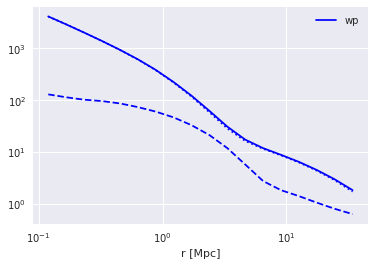

In [17]:
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[:18, :18]) ), label = 'wp', color = 'b')
plt.plot(rp_points, np.sqrt(np.diag(sim_cov[:18, :18]) ), color = 'b', ls = '--')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[:18, :18]) ), color = 'b', ls = ':')

plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

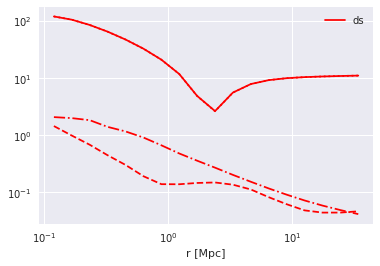

In [19]:
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36])) , label = 'ds', color ='r')
plt.plot(rp_points, np.sqrt(np.diag(sim_cov[18:36, 18:36]) ),  color = 'r', ls = '--')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':')
plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat)), color = 'r',  ls = '-.')

#plt.ylabel('Delta Sigma Unc')
plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

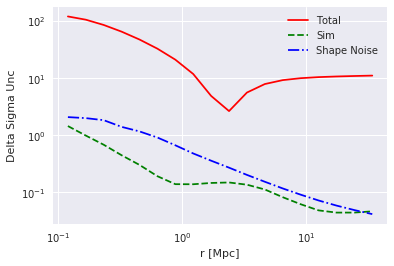

In [21]:
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36])) , label = 'Total', color ='r')
plt.plot(rp_points, np.sqrt(np.diag(sim_cov[18:36, 18:36]) ),  color = 'g', label = 'Sim', ls = '--')
#plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':')
plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat)), color = 'b', label = 'Shape Noise',ls = '-.')

plt.ylabel('Delta Sigma Unc')
plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

In [ ]:
0.7**2